In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
# collaborative_based_dataframe = pd.read_csv("./preprocessed_dataset/collaborative_based_dataframe.csv")
anime_df_merged = pd.read_csv('./preprocessed_dataset/anime_df_merged.csv')
# load all dataset
rating_df_lite_version = pd.read_csv('./preprocessed_dataset/rating_df_lite_version.csv')

In [3]:
df = rating_df_lite_version.copy()
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["anime_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["anime_id"].map(movie2movie_encoded)

In [4]:
df

,user_id,anime_id,rating,user,movie
0,1,8074,10,0,0
1,1,11617,10,0,1
2,1,11757,10,0,2
3,1,15451,10,0,3
4,2,11771,10,1,4
...,...,...,...,...,...
6337236,73515,16512,7,69598,56
6337237,73515,17187,9,69598,1802
6337238,73515,22145,10,69598,783
6337239,73516,790,9,69599,753


In [5]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

In [6]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 69600, Number of Movies: 9927, Min rating: 1.0, Max rating: 10.0


In [7]:
df = df.sample(frac=1, random_state=42)
df = df.sample(80000, random_state=45)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
class RecommenderNet(tf.keras.Model):

    # Insialisasi fungsi
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_anime = num_anime
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(  # layer embedding user
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(
            num_users, 1)  # layer embedding user bias
        
        self.anime_embedding = layers.Embedding(  # layer embeddings resto
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.anime_bias = layers.Embedding(
            num_anime, 1)  # layer embedding resto bias

    def call(self, inputs):
        user_vector = self.user_embedding(
            inputs[:, 0])  # memanggil layer embedding 1
        user_bias = self.user_bias(inputs[:, 0])  # memanggil layer embedding 2
        anime_vector = self.anime_embedding(
            inputs[:, 1])  # memanggil layer embedding 3
        # memanggil layer embedding 4
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

        x = dot_user_anime + user_bias + anime_bias

        return tf.nn.sigmoid(x)  # activation sigmoid

In [9]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
500/500 [==============================] - 36s 69ms/step - loss: 0.6718 - root_mean_squared_error: 0.2931 - val_loss: 0.6339 - val_root_mean_squared_error: 0.2580
Epoch 2/5
500/500 [==============================] - 35s 69ms/step - loss: 0.5556 - root_mean_squared_error: 0.1751 - val_loss: 0.6464 - val_root_mean_squared_error: 0.2697
Epoch 3/5
500/500 [==============================] - 35s 70ms/step - loss: 0.5479 - root_mean_squared_error: 0.1674 - val_loss: 0.6386 - val_root_mean_squared_error: 0.2625
Epoch 4/5
500/500 [==============================] - 35s 71ms/step - loss: 0.5438 - root_mean_squared_error: 0.1628 - val_loss: 0.6381 - val_root_mean_squared_error: 0.2622
Epoch 5/5
500/500 [==============================] - 36s 73ms/step - loss: 0.5408 - root_mean_squared_error: 0.1592 - val_loss: 0.6350 - val_root_mean_squared_error: 0.2592


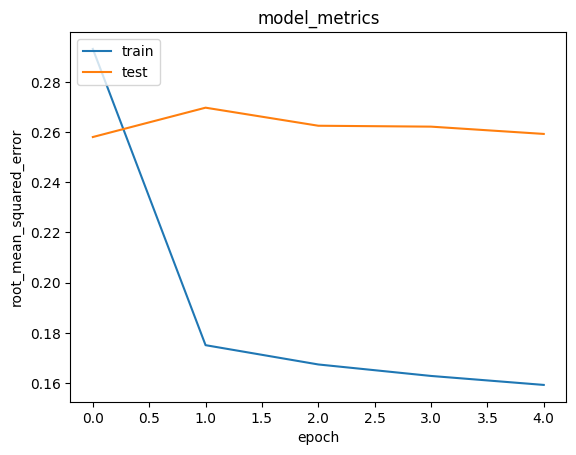

In [11]:
# visualisasi metrik
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
anime_new_df = anime_df_merged.copy()
anime_new_df['MAL_ID'] = anime_new_df['MAL_ID'].map(movie2movie_encoded)

In [56]:
# mendapatkan rekomendasi anime
# 1. ambil sampel user secara acak
sample_user_id = df.user_id.sample(1).iloc[0]
anime_watched_by_user = df[
    df['user_id']==sample_user_id
]


In [57]:
anime_watched_by_user

,user_id,anime_id,rating,user,movie
590472,6822,2713,7.0,6453,4435
590508,6822,3199,5.0,6453,4843
590339,6822,1105,2.0,6453,4044
590293,6822,825,6.0,6453,1819
590574,6822,4966,3.0,6453,6752
590401,6822,2006,4.0,6453,1635
590444,6822,2386,7.0,6453,2941
590589,6822,5292,6.0,6453,7419
590597,6822,5656,7.0,6453,1880
590655,6822,8678,6.0,6453,7434


In [58]:
# 2. anime not watched by user
anime_not_watched_by_user = anime_new_df[
    ~(anime_new_df['MAL_ID'].isin(anime_watched_by_user.anime_id.values))
]['MAL_ID']
anime_not_watched_by_user = list(
    set(anime_not_watched_by_user).intersection(set(movie2movie_encoded.keys()))
)
anime_not_watched_by_user = [
    [movie2movie_encoded.get(x)] for x in anime_not_watched_by_user
]

In [59]:
anime_not_watched_by_user

[[1031],
 [1032],
 [94],
 [2155],
 [3005],
 [95],
 [1582],
 [96],
 [97],
 [845],
 [5],
 [98],
 [5363],
 [99],
 [1499],
 [2156],
 [1762],
 [2280],
 [5721],
 [100],
 [514],
 [515],
 [1483],
 [717],
 [718],
 [101],
 [1583],
 [102],
 [1080],
 [2890],
 [1730],
 [2157],
 [1808],
 [1750],
 [1763],
 [2891],
 [3411],
 [103],
 [1764],
 [516],
 [1558],
 [719],
 [1840],
 [104],
 [517],
 [518],
 [846],
 [105],
 [106],
 [6024],
 [1220],
 [1111],
 [1500],
 [1584],
 [2624],
 [1568],
 [2319],
 [1721],
 [1585],
 [1765],
 [2578],
 [4616],
 [2579],
 [2320],
 [1586],
 [2321],
 [2580],
 [2625],
 [1484],
 [2876],
 [2626],
 [1731],
 [1732],
 [2322],
 [1081],
 [1044],
 [1722],
 [1723],
 [2132],
 [1526],
 [2158],
 [1698],
 [720],
 [2675],
 [2121],
 [3475],
 [1766],
 [2309],
 [2627],
 [519],
 [4696],
 [3029],
 [847],
 [2628],
 [2629],
 [4659],
 [5742],
 [2428],
 [721],
 [520],
 [722],
 [2133],
 [2877],
 [2429],
 [2430],
 [2710],
 [2711],
 [2159],
 [2160],
 [2161],
 [107],
 [797],
 [1634],
 [798],
 [108],
 [109],

In [60]:
# 3. prepare data user
user_encoder = user2user_encoded.get(sample_user_id)

In [61]:
user_encoder

6453

In [62]:
# 4. prepare user to anime array
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched_by_user), anime_not_watched_by_user)
)

In [63]:
user_anime_array

array([[6453, 1031],
       [6453, 1032],
       [6453,   94],
       ...,
       [6453, 4715],
       [6453,  825],
       [6453, 1537]])

In [66]:
# 5. predict rekomendasi
ratings = model.predict(user_anime_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]

180/180 [==============================] - 0s 2ms/step


In [71]:
recommended_anime_ids = [
    movie_encoded2movie.get(anime_not_watched_by_user[x][0]) for x in top_ratings_indices
]
print('Showing recommendations for users: {}'.format(sample_user_id))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)
anime_df_rows = anime_new_df[anime_new_df['MAL_ID'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.Name, ':', row.Genres)
    
    
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
recommended_anime = anime_new_df[anime_new_df['MAL_ID'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.Name, ':', row.Genres)

Showing recommendations for users: 6822
Anime with high ratings from user
--------------------------------
Galaxy Angel 3 Specials : Comedy, Sci-Fi
Nanaka 6/17 : Slice of Life, Comedy, Drama, Romance, Shounen
Time Bokan : Adventure, Comedy, Mecha
Amagami SS: Tachibana Miya-hen - Imouto : School
Love Live! Sunshine!! : Music, Slice of Life, School
--------------------------------
Top 10 anime recommendation
--------------------------------
.hack//Gift : Comedy, Fantasy, Game
Dragon Ball Z Movie 10: Kiken na Futari! Super Senshi wa Nemurenai : Action, Adventure, Comedy, Demons, Fantasy, Martial Arts, Shounen, Super Power
Yarima Queen : Comedy, Demons, Fantasy, Hentai, Magic, Parody
GS Mikami : Comedy, Supernatural
Junjou Romantica : Comedy, Drama, Romance, Shounen Ai
Kobato. : Comedy, Drama, Romance, Fantasy
Tetsuwan Birdy Decode: The Cipher : Action, Comedy, Sci-Fi
High School DxD : Comedy, Demons, Ecchi, Harem, Romance, School
Q Transformers: Kaette Kita Convoy no Nazo : Slice of Life,

In [73]:
anime_new_df[
    ~(anime_new_df['MAL_ID'].isna())
]

,MAL_ID,Name,Genres,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating
0,1031.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity)
1,1032.0,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,"Sep 1, 2001",Fall 2016,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity)
2,94.0,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older
3,2155.0,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older
4,3005.0,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Funimation,Toei Animation,Manga,23 min. per ep.,PG - Children
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,5878.0,Chiryokumaru,Action,ONA,1,"Nov 1, 2016",Fall 2016,NHK,Funimation,Studio 4°C,Original,2 min.,PG-13 - Teens 13 or older
12025,5208.0,Pokemon XY&Z Specials,"Action, Adventure, Comedy, Kids, Fantasy",Special,2,"Nov 3, 2016 to Nov 10, 2016",Fall 2016,NHK,The Pokemon Company International,OLM,Game,23 min. per ep.,PG - Children
12029,9081.0,Diamond no Ace: Second Season OVA,"Comedy, Sports, School, Shounen",OVA,2,"Aug 15, 2016 to Oct 17, 2016",Fall 2016,NHK,Funimation,"Production I.G, Madhouse",Manga,24 min. per ep.,PG-13 - Teens 13 or older
12034,9333.0,Long Riders! Recap,"Slice of Life, Comedy, Sports, Shounen",Special,1,"Nov 12, 2016",Fall 2016,NHK,Funimation,Actas,Manga,23 min.,PG-13 - Teens 13 or older


In [74]:
max(movie2movie_encoded.values())

9926